<a href="https://colab.research.google.com/github/DanyloVanin/PercussionHero_BreatheInTheAI/blob/main/PercussionHero_Splitting_and_Spectogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resources


# Initial configuration

1. Import libraries
1. Mount Google Drive folder with data using `Files -> Google Drive` option
2. Change from `.m4a` into `.wav`
4. Create several versions of audio with small shifts (e.g. `100 ms`)
3. Split into chunks (approx. 1 sec)
4. Change frame_rate from `48 000` to `16 000`
5. Split 2 channel audio into separate mono audio

In [ ]:
# Last TensorFlow version is used for some of the functionality 
%pip install -U --pre tensorflow

In [ ]:
%pip install tensorflow_io

In [ ]:
# PyPi Packet used for audio manipulation
%pip install pydub~=0.25.1

In [4]:
DATASET_PATH = 'drive/MyDrive/ML/Toronto_PercussionHero/Dataset'
PROCESSED_DATASET_PATH = 'sample_data/Dataset'
CLAPPED_SUBPATH = '/Clapped/Anterior'
CUPPED_SUBPATH = '/Cupped/Anterior'

CLAPPED_DATASET_PATH = DATASET_PATH + '/Clapped/Anterior'
CUPPED_DATASET_PATH = DATASET_PATH + '/Cupped/Anterior'

### .m4a to .wav convertion helper function

In [5]:
# Convert to WAV function
import os
from pydub import AudioSegment 

def convert_to_wav(input_dir, output_dir):
  for subdir, dirs, files in os.walk(input_dir):
    for file in files:
      filename = os.path.splitext(file)[0]
      new_filename = filename.replace('\.m4a', '\.wav')
      abs_path = os.path.abspath(os.path.join(input_dir, file))
      track = AudioSegment.from_file(abs_path,  format= 'm4a')
      file_handle = track.export(output_dir+new_filename, format='wav')
      

In [6]:
# convert_to_wav(CLAPPED_DATASET_PATH, 'sample_data/Dataset/Clapped/')
# convert_to_wav(CUPPED_DATASET_PATH, 'sample_data/Dataset/Cupped/')

### audio track information helper function
(channels, frame_rate, width)

In [7]:
import os
from pydub import AudioSegment 

def get_audio_info(input_dir):
  for subdir, dirs, files in os.walk(input_dir):
    for file in files:
      abs_path = os.path.abspath(os.path.join(input_dir, file))
      track = AudioSegment.from_file(abs_path,  format= 'wav')
      print('========')
      print(f"File: {file}")
      print(f"Frame rate: {track.frame_rate}")
      print(f"Channels: {track.channels}")
      print(f"Width: {track.sample_width }")
      print(track.frame_rate)


In [8]:
#get_audio_info('sample_data/Dataset/Clapped/')

### Main processing helper function


*   Converts `.m4a` to `.wav`
*   Sets frame rate to `16000`
*   Splits multiple channels into separate audio
*   Splits each audio into 1000 ms chunks
*   Saves all chunks into specified folder



In [9]:
from pydub import AudioSegment 
from pydub.utils import make_chunks



# Helping function for splitting file into chunks
def split_file_into_chunks(input_file, output_file, chunk_length_ms=1000, output_dir='./sample_data/chunked_audio/', shift=50):
  # Read as m4a
  full_audio = AudioSegment.from_file(input_file, format="m4a") 
  # Set frame rate
  full_audio = full_audio.set_frame_rate(16000)
  # Split to mono
  for j in range(int(chunk_length_ms/shift)):
    shifted_audio = full_audio[j*shift:]
    if shifted_audio.channels > 1:
      splitted_audio=shifted_audio.split_to_mono()
      for channel in range(len(splitted_audio)):
        chunks = make_chunks(splitted_audio[channel], chunk_length_ms)
        for i, audio_chunk in enumerate(chunks): 
            chunk_name = output_dir + output_file + f"_channel{channel}_shift{j*shift}_{i}.wav"
            audio_chunk.export(chunk_name, format="wav") 
    else: 
      chunks = make_chunks(shifted_audio, chunk_length_ms)
      for i, audio_chunk in enumerate(chunks): 
          chunk_name = output_dir + output_file + f"_shift{j*shift}_{i}.wav"
          audio_chunk.export(chunk_name, format="wav") 


In [10]:
import os

def split_files_into_chunks(input_dir, output_dir):
  for subdir, dirs, files in os.walk(input_dir):
    for file in files:
        filename = os.path.splitext(file)[0]
        abs_path = os.path.abspath(os.path.join(input_dir, file))
        split_file_into_chunks(abs_path, output_file=filename, chunk_length_ms=1000, output_dir=output_dir)

# Create dicrectory if not exists
if not os.path.exists(PROCESSED_DATASET_PATH+CLAPPED_SUBPATH):
    os.makedirs(PROCESSED_DATASET_PATH+CLAPPED_SUBPATH)

if not os.path.exists(PROCESSED_DATASET_PATH+CUPPED_SUBPATH):
    os.makedirs(PROCESSED_DATASET_PATH+CUPPED_SUBPATH)

# Split dataset files into chunks
split_files_into_chunks(CLAPPED_DATASET_PATH, PROCESSED_DATASET_PATH+CLAPPED_SUBPATH)
split_files_into_chunks(CUPPED_DATASET_PATH, PROCESSED_DATASET_PATH+CUPPED_SUBPATH)

### Directory cleaner helper function

In [11]:
import os

def clean_directory(directory):
  os.system(f'rm -rf {directory}/*')

def count_files_in_folder(directory):
  count = 0
  for path in os.listdir(directory):
      # check if current path is a file
      if os.path.isfile(os.path.join(directory, path)):
          count += 1
  print(f'Files in {directory}: ', count)
  return

count_files_in_folder('sample_data/Dataset/Clapped')
count_files_in_folder('sample_data/Dataset/Cupped')
os.system(f'rm -rf sample_data/Dataset/Clapped/Anterior')
os.system(f'rm -rf sample_data/Dataset/Cupped/Anterior')

# clean_directory('sample_data/Dataset/Clapped')
# clean_directory('sample_data/Dataset/Cupped')
os.system('rm -rf sample_data/Dataset/Cupped/.ipynb_checkpoints')
os.system('rm -rf sample_data/Dataset/Clapped/.ipynb_checkpoints')

Files in sample_data/Dataset/Clapped:  5705
Files in sample_data/Dataset/Cupped:  3111


0

# Data Processing


1. Import train/test/validation dataset
2. Convert audio to spectogram
3. Convert spectogram to mel-spectogram
4. Conver mel-spectogram to db-scale spectogram
5. Analyze/visualize data

### Imports for Tensorflow


In [12]:
# Import needed libraries
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from IPython import display

### Audio file to tensor decoding function
**(can be used for debugging)**

In [13]:
def decode_audio(file_name):
  raw_audio = tf.io.read_file(file_name)
  audio, _ = tf.audio.decode_wav(raw_audio)
  return tf.squeeze(audio, axis=-1)

In [14]:
def decode_audio_in_dir(dataset_dir):
  for subdir, dirs, files in os.walk(dataset_dir):
      for file in files:
        abs_path = os.path.abspath(os.path.join(dataset_dir, file))
        try:
          audio_tensor = decode_audio(abs_path)
          print('[+] Success:')
          print(audio_tensor)
        except: 
          print('[-] Fail:')
          print(file)

# decode_audio_in_dir('sample_data/Dataset/Clapped')

In [15]:
# Set seed for reproducible experiments
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

### Getting dataset 

In [16]:
# Delete .ipynb (can be created sometimes in dataset folder)
os.system('rm -rf sample_data/Dataset/.ipynb_checkpoints')

train_dataset, validation_dataset = tf.keras.utils.audio_dataset_from_directory(
    directory=PROCESSED_DATASET_PATH,
    batch_size=32,
    validation_split=0.4,
    seed=SEED,
    output_sequence_length=16000,
    subset='both')

Found 8816 files belonging to 2 classes.
Using 5290 files for training.
Using 3526 files for validation.


In [17]:
labels = ['Clapped', 'Cupped']
#print("Label names:", np.array(validation_dataset.class_names))
print("Element spec:", train_dataset.element_spec)

Element spec: (TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


## Dropping extra axis

In [18]:
# Drop the extra axis

def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_dataset = train_dataset.map(squeeze, tf.data.AUTOTUNE)
validation_dataset = validation_dataset.map(squeeze, tf.data.AUTOTUNE)

## Get an input example to play with

In [19]:
for example_audio, example_labels in train_dataset.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(32, 16000)
(32,)


## Spectrogram create/plot functions

In [20]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [21]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

## Input information function
* display waveform
* display spectrogram
* provide audioplayer
* display mel-spectrogram
* display db-scale spectrogram

In [22]:
import tensorflow_io as tfio

def get_audio_tensor_information(audio_tensor):
  # Audio listen
  display.display(display.Audio(audio_tensor, rate=16000))

  # Plot structure
  fig, axes = plt.subplots(2, figsize=(12, 8))
  
  # Waveform calculation
  timescale = np.arange(audio_tensor.shape[0])
  axes[0].plot(timescale, audio_tensor.numpy())
  axes[0].set_title('Waveform')
  axes[0].set_xlim([0, 16000])

  # Spectogram plot
  spectrogram = get_spectrogram(audio_tensor)
  plot_spectrogram(spectrogram.numpy(), axes[1])
  axes[1].set_title('Spectrogram')

  plt.show()

  # Convert to mel-spectrogram
  # mel_spectrogram = tfio.audio.melscale(
  #     spectrogram, rate=16000, mels=128, fmin=0, fmax=8000)
  # plt.figure()
  # plt.imshow(tf.math.log(mel_spectrogram).numpy())
  

  # # Convert to db scale mel-spectrogram
  # dbscale_mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=80)

  # plt.figure()
  # plt.imshow(dbscale_mel_spectrogram.numpy())

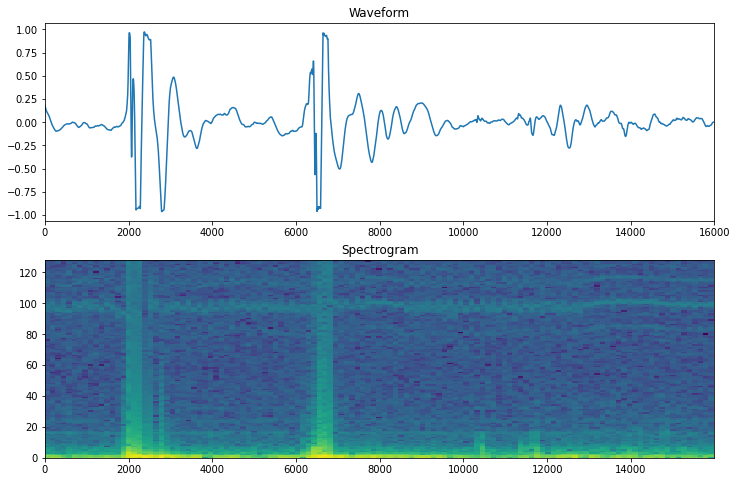

In [23]:
get_audio_tensor_information(example_audio[3])

# Model

## Turning audio datasets into spectrogram datasets

In [24]:
def make_spectrogram_dataset(dataset):
  return dataset.map(
      map_func=lambda audio, label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [25]:
test_dataset = validation_dataset.shard(num_shards=2, index=0)
validation_dataset = validation_dataset.shard(num_shards=2, index=1)

In [26]:
train_spectrogram_ds = make_spectrogram_dataset(train_dataset)
val_spectrogram_ds = make_spectrogram_dataset(validation_dataset)
test_spectrogram_ds = make_spectrogram_dataset(test_dataset)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


## Displaying some example spectrograms for labels

In [27]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

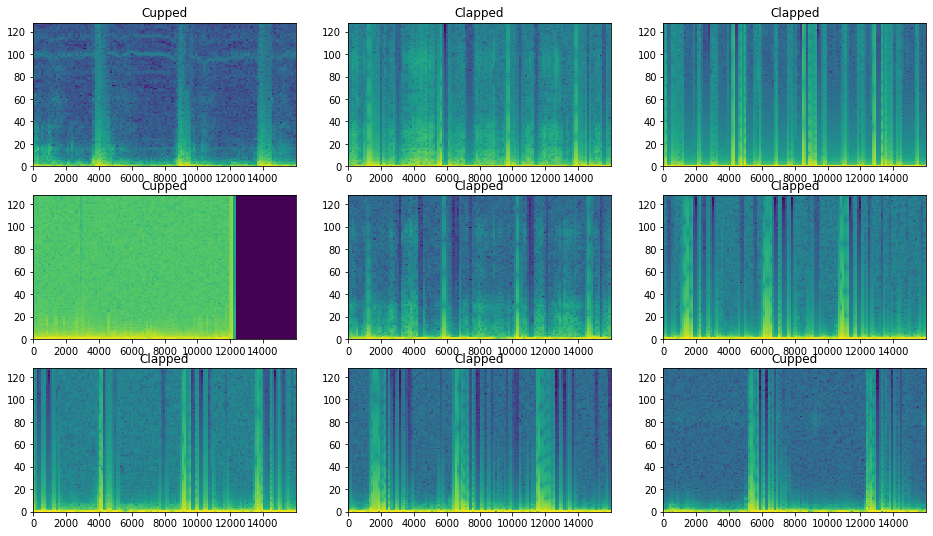

In [28]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(labels[example_spect_labels[i].numpy()])

plt.show()

## Shuffle and imports

In [29]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [30]:
from tensorflow.keras import layers
from tensorflow.keras import models

## Model configuration

In [31]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(labels)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           

## Model Compile

In [32]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

## Model Fit

In [33]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS
)

Epoch 1/10
166/166 [==============================] - 28s 165ms/step - loss: 0.5784 - accuracy: 0.6760 - val_loss: 0.4721 - val_accuracy: 0.7795
Epoch 2/10
166/166 [==============================] - 26s 155ms/step - loss: 0.4425 - accuracy: 0.7794 - val_loss: 0.3462 - val_accuracy: 0.8585
Epoch 3/10
166/166 [==============================] - 27s 161ms/step - loss: 0.3288 - accuracy: 0.8491 - val_loss: 0.2919 - val_accuracy: 0.8466
Epoch 4/10
166/166 [==============================] - 27s 162ms/step - loss: 0.2513 - accuracy: 0.8921 - val_loss: 0.1908 - val_accuracy: 0.9227
Epoch 5/10
166/166 [==============================] - 23s 140ms/step - loss: 0.1964 - accuracy: 0.9210 - val_loss: 0.1601 - val_accuracy: 0.9369
Epoch 6/10
166/166 [==============================] - 23s 137ms/step - loss: 0.1730 - accuracy: 0.9316 - val_loss: 0.1483 - val_accuracy: 0.9438
Epoch 7/10
166/166 [==============================] - 30s 178ms/step - loss: 0.1650 - accuracy: 0.9340 - val_loss: 0.1324 - val_ac

## Model Evaluate

In [34]:
model.evaluate(test_spectrogram_ds, return_dict=True)

56/56 [==============================] - 7s 122ms/step - loss: 0.1259 - accuracy: 0.9485


{'loss': 0.1258772909641266, 'accuracy': 0.9484711289405823}

## Confusion Matrix

56/56 [==============================] - 2s 30ms/step


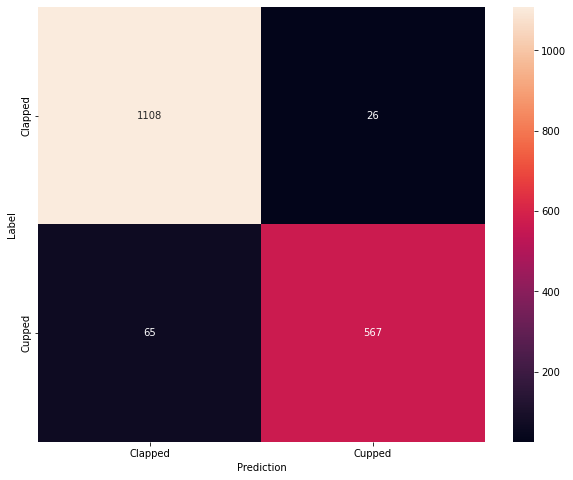

In [35]:
y_pred = model.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=labels,
            yticklabels=labels,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

# To-DO 

1. Generate mel-spectogram for further comparison
2. Generate db-scale spectogram for further comparison

**Future:**
1. Create data processing pipeline as in [here](https://towardsdatascience.com/how-to-easily-process-audio-on-your-gpu-with-tensorflow-2d9d91360f06)
1. Read series of articles on audio deep learning [here](https://towardsdatascience.com/audio-deep-learning-made-simple-part-3-data-preparation-and-augmentation-24c6e1f6b52)


